In [ ]:
from google.colab import drive
drive.mount('/content/drive')

 Article Reference: https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/


In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
image_path = "/content/drive/MyDrive/BT5153/Data/Pict"
dir_img_csv = pd.read_csv("/content/drive/MyDrive/BT5153/Data/Data_processed_reduced_v2.csv",encoding= 'unicode_escape')

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 49111


In [ ]:
dir_img_csv['filename'] = dir_img_csv['img_id'].apply(lambda x: str(x)+'.jpg')
dir_img_csv = dir_img_csv[['img_id', 'filename','description']]
dir_img_csv.columns = ['index','filename', 'caption']
data = dir_img_csv.copy()

uni_filenames = np.unique(data.filename.values)
data.head()

,index,filename,caption
0,0,0.jpg,A single layer with a natural feel of natural ...
1,1,1.jpg,Light and cool shorts are perfect for relaxing...
2,2,2.jpg,Updated to have a relaxed silhouette. Has a mo...
3,3,3.jpg,Shorts inspired by military pants. Trendy loos...
4,4,4.jpg,Updated to have a relaxed silhouette. Has a mo...


In [ ]:
'''
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']


uni_filenames = np.unique(data.filename.values)
data.head()
'''

'\nfile = open(dir_Flickr_text,\'r\')\ntext = file.read()\nfile.close()\n\ndatatxt = []\nfor line in text.split(\'\n\'):\n    col = line.split(\'\t\')\n    if len(col) == 1:\n        continue\n    w = col[0].split("#")\n    datatxt.append(w + [col[1].lower()])\n\ndata = pd.DataFrame(datatxt,columns=["filename","index","caption"])\ndata = data.reindex(columns =[\'index\',\'filename\',\'caption\'])\ndata = data[data[\'filename\'] != \'2258277193_586949ec62.jpg.1\']\n\n\nuni_filenames = np.unique(data.filename.values)\ndata.head()\n'

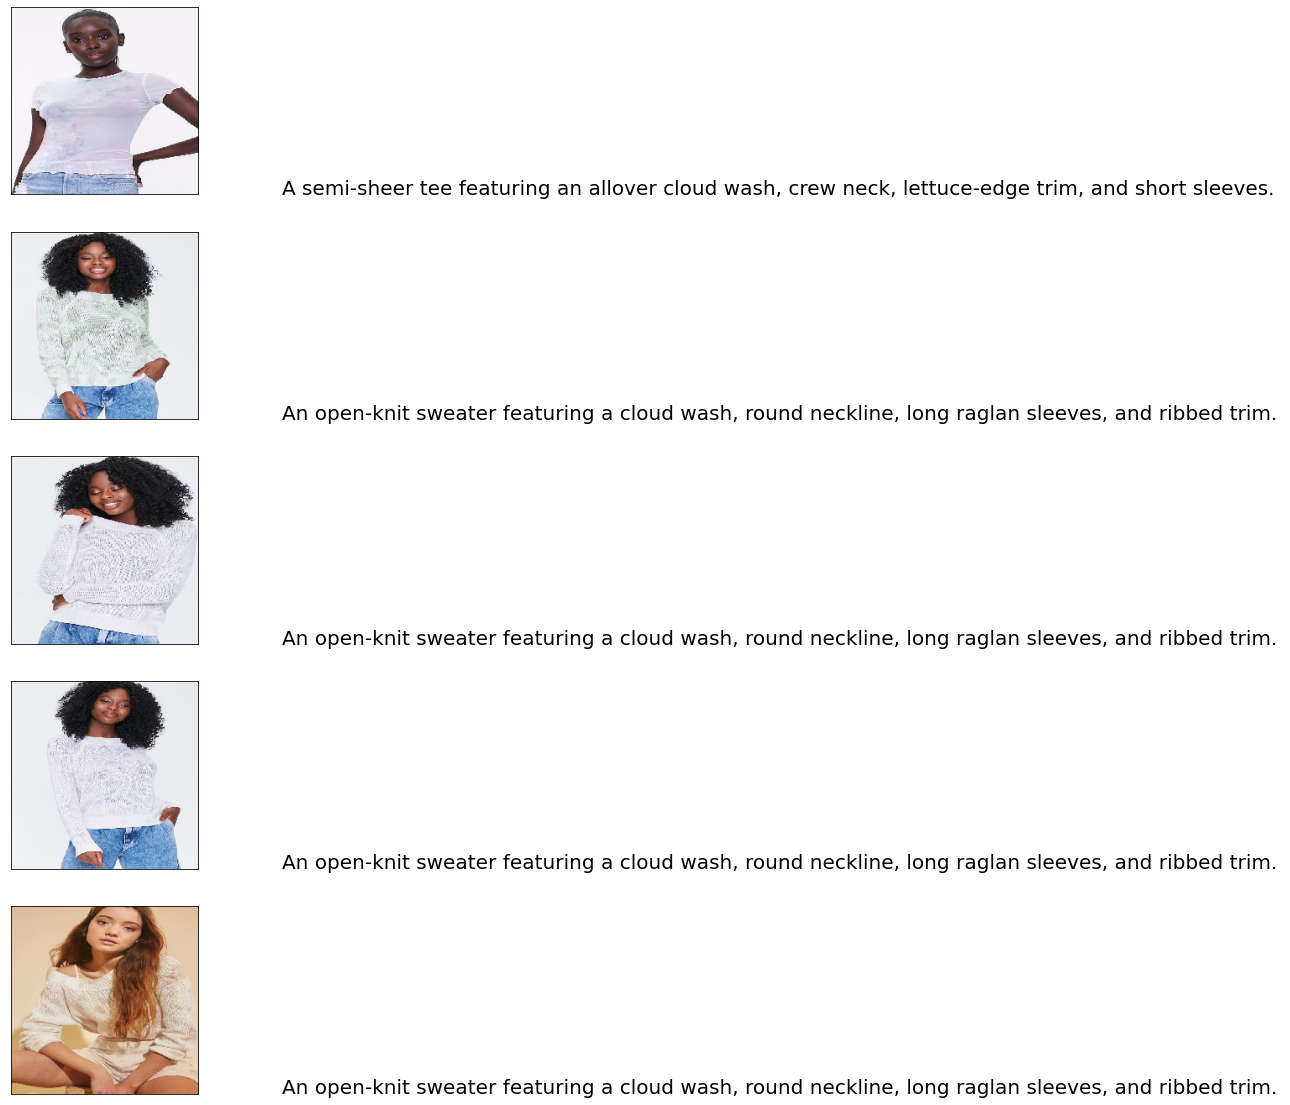

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 18198


In [ ]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 21357
len(caption) : 21357


In [ ]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 9115


In [ ]:
PATH = "/content/drive/MyDrive/BT5153/Data/Pict/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start>  single layer with natural feel of natural Simple and easy to natural linen cotton blend fabric for breathability and regular fit that goes great with the the natural feeling of linen There is drawstring around the waist for easy Features streamlined knee <end>',
 '<start>  Light and cool shorts are perfect for Convenient pockets for carrying small Pockets have new Waist spindle is now on the Tonal color leaf <end>',
 '<start>  Updated to have relaxed Has more casual feeling while still being Made with cotton twill dense and soft to the The updates for this season include slightly more relaxed silhouette perfect for pairing with oversized or fitted Updated to have more casual stitch <end>',
 '<start>  Shorts inspired by military Trendy The Uniqlo collection is the realization of dedicated and skilled team of international designers based at our Paris Research and Development Center led by Artistic Director Christophe Used lightweight cotton Carefully designed to last with det

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/0.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/1.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/3.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/4.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/5.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/6.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/7.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/8.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/9.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 21357
len(all_captions) : 21357


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(30000, all_captions,all_img_name_vector)

In [ ]:
img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/22701.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2772.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/22132.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/23465.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/10405.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/532.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/23833.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/16782.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/14516.jpg']

In [ ]:
train_captions[:10]

['<start>  jeans in stretch denim with fake front real back pockets and skinny Wide waist panel for best fit over the <end>',
 '<start>  Stay cool and ready for anything in this AEROREADY keeps you feeling and the extra coverage lets you move comfortably and confidently throughout your The adidas Badge of Sport and complete the sportswear This product is made with series of recycled <end>',
 '<start>  Outdoor jacket in woven fabric with stand up collar and zip down the front with chin Padded front and back zipped side long raglan sleeves with thumbholes at the cuffs and inset side panels in sturdy jersey lined with thermal Longer and rounded at the Partly <end>',
 '<start>  Jumper in viscose blend with boat neck and <end>',
 '<start>  drawstring in luxurious cotton loungewear in variety of soothing of the Premium Collection by in <end>',
 '<start>  knit crop top featuring crossover long and round <end>',
 '<start>  These cropped pants are easy to coordinate with your Explore styling op

In [ ]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 21357
len(all_captions) : 21357


In [ ]:
df_to_use = pd.DataFrame({"captions":train_captions, 'pics':img_name_vector})
df_to_use['img_id'] = df_to_use['pics'].apply(lambda x: x.split('/')[-1][:-4])
df_to_use.head(10)

,captions,pics,img_id
0,<start> jeans in stretch denim with fake fron...,/content/drive/MyDrive/BT5153/Data/Pict/22701.jpg,22701
1,<start> Stay cool and ready for anything in t...,/content/drive/MyDrive/BT5153/Data/Pict/2772.jpg,2772
2,<start> Outdoor jacket in woven fabric with s...,/content/drive/MyDrive/BT5153/Data/Pict/22132.jpg,22132
3,<start> Jumper in viscose blend with boat nec...,/content/drive/MyDrive/BT5153/Data/Pict/23465.jpg,23465
4,<start> drawstring in luxurious cotton lounge...,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,17311
5,<start> knit crop top featuring crossover lon...,/content/drive/MyDrive/BT5153/Data/Pict/10405.jpg,10405
6,<start> These cropped pants are easy to coord...,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,532
7,<start> gathered top in jersey with vertical ...,/content/drive/MyDrive/BT5153/Data/Pict/23833.jpg,23833
8,<start> knit matching set in an allover wash ...,/content/drive/MyDrive/BT5153/Data/Pict/16782.jpg,16782
9,<start> ribbed knit top featuring long and mo...,/content/drive/MyDrive/BT5153/Data/Pict/14516.jpg,14516


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
'''
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
'''

'\n# Get unique images\nencode_train = sorted(set(img_name_vector))\n\n# Feel free to change batch_size according to your system configuration\nimage_dataset = tf.data.Dataset.from_tensor_slices(encode_train)\nimage_dataset = image_dataset.map(\n  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)\n\nfor img, path in tqdm(image_dataset):\n  batch_features = image_features_extract_model(img)\n  batch_features = tf.reshape(batch_features,\n                              (batch_features.shape[0], -1, batch_features.shape[3]))\n\n  for bf, p in zip(batch_features, path):\n    path_of_feature = p.numpy().decode("utf-8")\n    np.save(path_of_feature, bf.numpy())\n'

In [ ]:
top_k = 12400

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=62,padding='post')
cap_vector.shape

(21357, 62)

In [ ]:
img_name_vector[:10]

['/content/drive/MyDrive/BT5153/Data/Pict/22701.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/2772.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/22132.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/23465.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/10405.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/532.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/23833.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/16782.jpg',
 '/content/drive/MyDrive/BT5153/Data/Pict/14516.jpg']

In [ ]:
### load pre-prepared train and test set for consistency
predefined_train = pd.read_csv('/content/drive/MyDrive/BT5153/Data/df_train.csv')
predefined_val = pd.read_csv('/content/drive/MyDrive/BT5153/Data/df_validation.csv')

In [ ]:
predefined_train_ids = predefined_train['img_id']
predefined_val_ids = predefined_val['img_id']

In [ ]:
img_name_train_trial = []
img_name_val_trial = []
cap_train_trial = []
cap_val_trial = []

for i in range(len(img_name_vector)):
  temp_img = img_name_vector[i]
  temp_img_ids = int(temp_img.split('/')[-1][:-4])
  if temp_img_ids in predefined_train_ids.values:
    img_name_train_trial.append(temp_img)
    cap_train_trial.append(cap_vector[i])
  elif temp_img_ids in predefined_val_ids.values:
    img_name_val_trial.append(temp_img)
    cap_val_trial.append(cap_vector[i])
  else:
    continue



In [ ]:
cap_val = np.array(cap_val_trial)
cap_train = np.array(cap_train_trial)
img_name_train = img_name_train_trial
img_name_val = img_name_val_trial
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(17086, 17086, 4271, 4271)

In [ ]:
'''
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=123)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
'''

'\nimg_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,\n                                                                    cap_vector,\n                                                                    test_size=0.2,\n                                                                    random_state=123)\nlen(img_name_train), len(cap_train), len(img_name_val), len(cap_val)\n'

In [ ]:
cap_train.shape

(17086, 62)

In [ ]:
img_name_train_new = [] 
for i in img_name_train:
  temp_split = i.split("/")
  temp_file = temp_split[-1][:-4]
  temp_new_path = "/".join(temp_split[:-2]+['Pict_features_transformer', temp_file])
  img_name_train_new.append(temp_new_path)

img_name_train = img_name_train_new

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
num_layer = 6 # original = 4
d_model = 50 # original = 96
dff = 2048
num_heads = 5 # original = 8
row_size = 62 # original = 8  
col_size = 62 # original = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(10):   # first round: 5 + 7 epochs
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.4398 Accuracy 0.0000
Epoch 1 Batch 50 Loss 9.4084 Accuracy 0.0002
Epoch 1 Batch 100 Loss 9.3467 Accuracy 0.0017
Epoch 1 Batch 150 Loss 9.2588 Accuracy 0.0078
Epoch 1 Batch 200 Loss 9.1383 Accuracy 0.0119
Epoch 1 Batch 250 Loss 8.9868 Accuracy 0.0144
Epoch 1 Loss 8.9325 Accuracy 0.0150
Time taken for 1 epoch: 2477.0677218437195 secs

Epoch 2 Batch 0 Loss 7.9883 Accuracy 0.0297
Epoch 2 Batch 50 Loss 7.7522 Accuracy 0.0243
Epoch 2 Batch 100 Loss 7.4951 Accuracy 0.0245
Epoch 2 Batch 150 Loss 7.2503 Accuracy 0.0267
Epoch 2 Batch 200 Loss 7.0327 Accuracy 0.0288
Epoch 2 Batch 250 Loss 6.8495 Accuracy 0.0304
Epoch 2 Loss 6.7989 Accuracy 0.0309
Time taken for 1 epoch: 1017.0197415351868 secs

Epoch 3 Batch 0 Loss 6.0547 Accuracy 0.0318
Epoch 3 Batch 50 Loss 5.9071 Accuracy 0.0392
Epoch 3 Batch 100 Loss 5.8101 Accuracy 0.0415
Epoch 3 Batch 150 Loss 5.7046 Accuracy 0.0481
Epoch 3 Batch 200 Loss 5.5982 Accuracy 0.0536
Epoch 3 Batch 250 Loss 5.4861 Accuracy 0.0584
Epoch 3 Los

In [ ]:
transformer.save_weights('/content/drive/MyDrive/BT5153_transformer_test/Model_weights/5153_transformer_v2Data_10epoch.h5')

BLEU-1 score: 27.77777777777778
BLEU-2 score: 22.140372138502386
BLEU-3 score: 21.686224715380213
BLEU-4 score: 14.216645907653843
Real Caption: blouse in woven fabric with elastication around the top and short
Predicted Caption: trousers in woven fabric with high zip fly and concealed side fake back pockets and tapered legs with


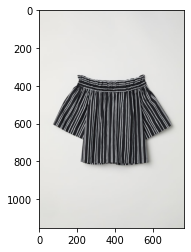

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(32):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [ ]:
df_val_results = pd.DataFrame(columns=['img_path','real_caption','predicted_caption','bleu_1', 'bleu_2', 'bleu_3', 'bleu_4'])

In [ ]:
range(len(img_name_val))

range(0, 4271)

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
for rid in range(len(img_name_val)):

  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
        caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption
  score_1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  score_2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  score_3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  score_4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

  temp_val_df = pd.DataFrame({
      'img_path':[image],
      'real_caption':[real_caption],
      'predicted_caption':[' '.join(caption)],
      'bleu_1':[score_1], 
      'bleu_2':[score_2], 
      'bleu_3':[score_3], 
      'bleu_4':[score_4]
  })

  df_val_results = pd.concat([df_val_results, temp_val_df], axis=0)


In [ ]:
df_val_results.head()

,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4
0,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.224820,0.369549,0.418438
0,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.135593,0.048351,0.162421,0.219888
0,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.224820,0.369549,0.418438
0,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.135593,0.048351,0.162421,0.219888
0,/content/drive/MyDrive/BT5153/Data/Pict/18526.jpg,shirt in cotton weave with grandad classic fro...,shirt in cotton weave with buttons down the fr...,0.429005,0.346152,0.285263,0.180608


In [ ]:
df_val_results.to_csv('/content/drive/MyDrive/BT5153_transformer_test/Val_resutls/val_results_v2Data_10epoch_part2.csv', index=False)

In [ ]:
### Calculate the BLEU scores using smoothing
bleu_results_raw = pd.read_csv('C:/NUS MSBA/BT 5153/GP/Val_resutls/val_results_v2Data_10epoch_all.csv')

In [ ]:
bleu_results_raw.head()

,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4
0,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.224820,0.369549,0.418438
1,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.135593,0.048351,0.162421,0.219888
2,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.224820,0.369549,0.418438
3,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.135593,0.048351,0.162421,0.219888
4,/content/drive/MyDrive/BT5153/Data/Pict/18526.jpg,shirt in cotton weave with grandad classic fro...,shirt in cotton weave with buttons down the fr...,0.429005,0.346152,0.285263,0.180608


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
bleu_results_smooth = pd.DataFrame(columns = bleu_results_raw.columns)
for i in range(len(bleu_results_raw)):
    reference = bleu_results_raw.iloc[i,1].split()
    if len(reference) > 32:
        reference = reference[:32]
    
    candidate = bleu_results_raw.iloc[i,2].split()
    if len(candidate) > 32:
        candidate = candidate[:32]
    
    temp_path = bleu_results_raw.iloc[i,0]
    
    score_1 = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function = SmoothingFunction().method4)
    score_2 = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function = SmoothingFunction().method4)
    score_3 = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function = SmoothingFunction().method4)
    score_4 = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25),smoothing_function = SmoothingFunction().method4)
    
    temp_df = pd.DataFrame({
      'img_path':[temp_path],
      'real_caption':[' '.join(reference)],
      'predicted_caption':[' '.join(candidate)],
      'bleu_1':[score_1], 
      'bleu_2':[score_2], 
      'bleu_3':[score_3], 
      'bleu_4':[score_4]
    })
    
    bleu_results_smooth = pd.concat([bleu_results_smooth, temp_df], axis=0)
    

In [ ]:
bleu_results_smooth.head()

,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4
0,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.117646,0.190515,0.208109
0,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.187500,0.121550,0.147498,0.126950
0,/content/drive/MyDrive/BT5153/Data/Pict/17311.jpg,drawstring in luxurious cotton loungewear in v...,the nike sportswear trousers are made from sof...,0.064900,0.117646,0.190515,0.208109
0,/content/drive/MyDrive/BT5153/Data/Pict/532.jpg,these cropped pants are easy to coordinate wit...,the uniqlo collection is the realization of de...,0.187500,0.121550,0.147498,0.126950
0,/content/drive/MyDrive/BT5153/Data/Pict/18526.jpg,shirt in cotton weave with grandad classic fro...,shirt in cotton weave with buttons down the fr...,0.483702,0.390285,0.321633,0.203635


In [ ]:
bleu_results_smooth.describe()

,bleu_1,bleu_2,bleu_3,bleu_4
count,4273.000000,4273.000000,4273.000000,4273.000000
mean,0.288072,0.211392,0.234583,0.235792
std,0.179352,0.142733,0.140810,0.161922
min,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.102848,0.134488,0.121294
50%,0.260870,0.174121,0.196201,0.179090
75%,0.404354,0.292523,0.307967,0.309584
max,1.000000,1.000000,1.000000,1.095177


In [ ]:
bleu_results_smooth['real_caption'].apply(lambda x: len(x.split())).max()

32

In [ ]:
bleu_results_smooth['predicted_caption'].apply(lambda x: len(x.split())).max()

32

In [ ]:
bleu_results_smooth['img_id'] = bleu_results_smooth['img_path'].apply(lambda x: x.split('/')[-1][:-4])
bleu_results_smooth = bleu_results_smooth.drop_duplicates(subset=['img_id'])

In [ ]:
bleu_results_smooth.shape

(4271, 8)

In [ ]:
bleu_results_smooth.to_csv('transformer_BLEU.csv',index=False)